KGAT_b9317532b20a904317ac3211038725ed

In [1]:
import os
# Masukkan kredensial Kaggle Anda
os.environ['KAGGLE_USERNAME'] = "Saifuddin Tamam"
os.environ['KAGGLE_KEY'] = "KGAT_b9317532b20a904317ac3211038725ed"

# Download & Unzip
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
!unzip -q ocular-disease-recognition-odir5k.zip -d odir_dataset
print("✓ Dataset Siap!")

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k
License(s): other
 93% 1.51G/1.62G [00:11<00:02, 41.3MB/s]
100% 1.62G/1.62G [00:11<00:00, 149MB/s] 
✓ Dataset Siap!


In [2]:
import pandas as pd
import numpy as np
import os
import cv2
import glob
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle

# Load CSV
csv_path = glob.glob('odir_dataset/*.csv')[0]
df = pd.read_csv(csv_path)

# Mapping Label Utama
def get_label(row):
    for label in ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']:
        if row[label] == 1: return label
    return 'N'

df['target'] = df.apply(get_label, axis=1)

# Deteksi Folder Gambar
image_dir = 'odir_dataset/preprocessed_images'
df = df[df['filename'].apply(lambda x: os.path.exists(os.path.join(image_dir, x)))].reset_index(drop=True)

# OVERSAMPLING (Penyeimbangan Data)
target_count = 1500
balanced_list = []
for label in ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']:
    class_df = df[df['target'] == label]
    resampled = resample(class_df, replace=True, n_samples=target_count, random_state=42)
    balanced_list.append(resampled)

df_balanced = pd.concat(balanced_list)
print("Distribusi Data Baru:\n", df_balanced['target'].value_counts())

# Simpan Label Encoder untuk VS Code nanti
le = LabelEncoder()
df_balanced['label_idx'] = le.fit_transform(df_balanced['target'])
with open('label_encoder_mn.pkl', 'wb') as f:
    pickle.dump(le, f)

Distribusi Data Baru:
 target
N    1500
D    1500
G    1500
C    1500
A    1500
H    1500
M    1500
O    1500
Name: count, dtype: int64


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Fungsi Penajaman Medis (CLAHE)
def apply_clahe_medis(img):
    img = (img * 255).astype(np.uint8) if img.max() <= 1.0 else img.astype(np.uint8)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l = clahe.apply(l)
    img = cv2.merge([l, a, b])
    return cv2.cvtColor(img, cv2.COLOR_LAB2RGB)

def final_preprocess(img):
    img = apply_clahe_medis(img) # Tajamkan
    return preprocess_input(img) # Normalisasi MobileNetV2

# Split Data
train_df, val_df = train_test_split(df_balanced, test_size=0.15, stratify=df_balanced['target'], random_state=42)

# Generators
datagen = ImageDataGenerator(
    preprocessing_function=final_preprocess,
    rotation_range=20, horizontal_flip=True, zoom_range=0.1
)
val_datagen = ImageDataGenerator(preprocessing_function=final_preprocess)

train_gen = datagen.flow_from_dataframe(
    train_df, directory=image_dir, x_col='filename', y_col='target',
    target_size=(224, 224), batch_size=32, class_mode='categorical'
)

val_gen = val_datagen.flow_from_dataframe(
    val_df, directory=image_dir, x_col='filename', y_col='target',
    target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False
)

Found 10200 validated image filenames belonging to 8 classes.
Found 1800 validated image filenames belonging to 8 classes.


In [5]:
from tensorflow.keras import layers, models, optimizers, callbacks

# Load MobileNetV2
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(8, activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,268,232 (8.65 MB)

 Trainable params: 2,234,120 (8.52 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [6]:
# --- PHASE 1: PEMANASAN ---
base_model.trainable = False
model.compile(optimizer=optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

print("\n=== Phase 1: Pemanasan ===")
history1 = model.fit(train_gen, validation_data=val_gen, epochs=10)



=== Phase 1: Pemanasan ===


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 197s 558ms/step - accuracy: 0.3280 - loss: 1.8755 - val_accuracy: 0.4806 - val_loss: 1.4038
Epoch 2/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 151s 475ms/step - accuracy: 0.4858 - loss: 1.4074 - val_accuracy: 0.4833 - val_loss: 1.3364
Epoch 3/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 149s 468ms/step - accuracy: 0.5072 - loss: 1.3521 - val_accuracy: 0.5106 - val_loss: 1.3238
Epoch 4/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 149s 466ms/step - accuracy: 0.5186 - loss: 1.2815 - val_accuracy: 0.5256 - val_loss: 1.2314
Epoch 5/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 147s 461ms/step - accuracy: 0.5361 - loss: 1.2308 - val_accuracy: 0.5306 - val_loss: 1.2190
Epoch 6/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 203s 466ms/step - accuracy: 0.5474 - loss: 1.2210 - val_accuracy: 0.5144 - val_loss: 1.2343
Epoch 7/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 147s 462ms/step - accuracy: 0.5579 - loss: 1.1924 - val_accuracy: 0.5594 - val_loss: 1.1865
Epoch 8/10
319/319 ━━━━━━━━━━━━━━━━━━━━ 148s 465ms/step - accuracy: 0.5630 -

In [7]:
# --- PHASE 2: FINE-TUNING (SANGAT DETAIL) ---
base_model.trainable = True
# Buka layer atas agar spesialis medis
for layer in base_model.layers[:100]: layer.trainable = False

model.compile(optimizer=optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

print("\n=== Phase 2: Fine-Tuning Spesialis Mata ===")
history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[
        callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(factor=0.2, patience=2)
    ]
)

model.save('mobilenetv2_ocular_final.h5')


=== Phase 2: Fine-Tuning Spesialis Mata ===
Epoch 1/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 188s 524ms/step - accuracy: 0.3485 - loss: 2.4781 - val_accuracy: 0.4722 - val_loss: 1.5205 - learning_rate: 1.0000e-05
Epoch 2/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 152s 476ms/step - accuracy: 0.4781 - loss: 1.4957 - val_accuracy: 0.4961 - val_loss: 1.4380 - learning_rate: 1.0000e-05
Epoch 3/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 151s 474ms/step - accuracy: 0.5202 - loss: 1.3111 - val_accuracy: 0.5383 - val_loss: 1.2938 - learning_rate: 1.0000e-05
Epoch 4/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 151s 472ms/step - accuracy: 0.5473 - loss: 1.2197 - val_accuracy: 0.5811 - val_loss: 1.1771 - learning_rate: 1.0000e-05
Epoch 5/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 153s 480ms/step - accuracy: 0.5862 - loss: 1.1108 - val_accuracy: 0.5889 - val_loss: 1.0956 - learning_rate: 1.0000e-05
Epoch 6/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 152s 475ms/step - accuracy: 0.6083 - loss: 1.0601 - val_accuracy: 0.6094 - val_loss: 1.0245 - learning_rate: 1.0000

57/57 ━━━━━━━━━━━━━━━━━━━━ 16s 214ms/step

===== CLASSIFICATION REPORT MOBILE NET V2 =====
              precision    recall  f1-score   support

           A       0.90      0.94      0.92       225
           C       0.93      0.92      0.92       225
           D       0.72      0.22      0.33       225
           G       0.84      0.88      0.86       225
           H       0.97      1.00      0.98       225
           M       0.99      0.93      0.96       225
           N       0.45      0.60      0.51       225
           O       0.45      0.59      0.51       225

    accuracy                           0.76      1800
   macro avg       0.78      0.76      0.75      1800
weighted avg       0.78      0.76      0.75      1800



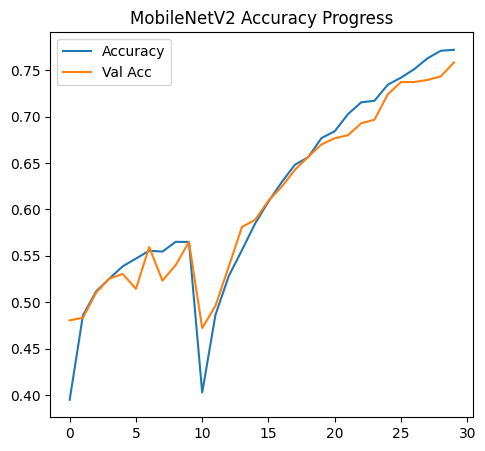

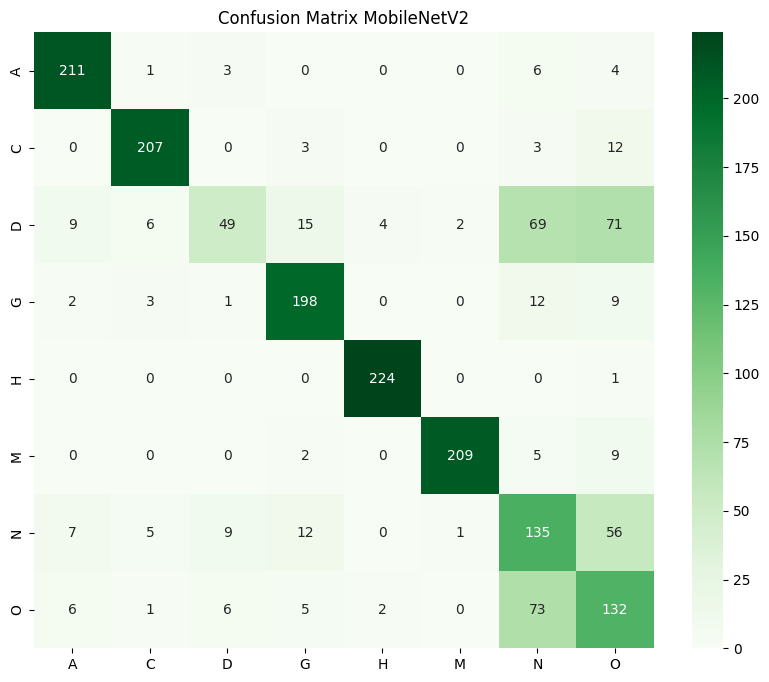

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Prediksi
val_gen.reset()
y_pred = np.argmax(model.predict(val_gen), axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# Plot Grafik
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'] + history2.history['accuracy'], label='Accuracy')
plt.plot(history1.history['val_accuracy'] + history2.history['val_accuracy'], label='Val Acc')
plt.title('MobileNetV2 Accuracy Progress')
plt.legend()

# Classification Report
print("\n===== CLASSIFICATION REPORT MOBILE NET V2 =====")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix MobileNetV2')
plt.show()

# Download file untuk VS Code
from google.colab import files
files.download('mobilenetv2_ocular_final.h5')
files.download('label_encoder_mn.pkl')